In [48]:
import tqdm

%load_ext autoreload
%autoreload 2
import sys
import os
print(os.environ['LD_LIBRARY_PATH'])
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/usr/local/cuda-12.6/lib64:~/.virtualenvs/dopamine/lib/python3.10/site-packages/nvidia/cudnn//lib:/home/eop/.mujoco/mujoco210/bin:/usr/lib/nvidia


'/home/eop/code/CORL/venv/bin/python'

In [49]:
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import d4rl
import gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm, trange
import multiprocessing

multiprocessing.set_start_method('spawn', force=True)

In [50]:
env_name = 'halfcheetah-medium-v2'
env = gym.make(env_name)
dataset = env.get_dataset()
torch.set_default_device('cuda')

load datafile: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.66it/s]


In [51]:
from algorithms.offline.knn import load_d4rl_trajectories

In [52]:
trajs, infos = load_d4rl_trajectories(env_name)
obs_shape = trajs[0]['observations'].shape[1]
action_shape=trajs[0]['actions'].shape[1]
obs_mean = infos['obs_mean']
obs_std = infos['obs_std']
print(obs_shape, action_shape)

load datafile: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.49it/s]


Processing trajectories:   0%|          | 0/1000000 [00:00<?, ?it/s]

17 6


In [69]:
np.histogram(np.array([1,2,3,1]), bins='auto')[0]

array([2, 1, 1])

In [53]:
[infos

{'obs_mean': array([[-0.06845774,  0.01641455, -0.18354906, -0.27624607, -0.34061527,
         -0.09339716, -0.21321271, -0.08774239,  5.1730075 , -0.04275195,
         -0.03610836,  0.14053793,  0.06049833,  0.09550975,  0.067391  ,
          0.00562739,  0.01338279]], dtype=float32),
 'obs_std': array([[ 0.07472999,  0.30234998,  0.3020731 ,  0.34417078,  0.17619242,
          0.5072056 ,  0.25670078,  0.32948127,  1.2574149 ,  0.7600542 ,
          1.9800916 ,  6.5653625 ,  7.4663677 ,  4.472223  , 10.566964  ,
          5.6719327 ,  7.498259  ]], dtype=float32),
 'reward_mean': array([4.7703357], dtype=float32),
 'reward_std': array([1.2101753], dtype=float32),
 'traj_lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 100

In [54]:
rollout_len = 5
indices_to_remove = []
for ind, traj in enumerate(trajs):
    if (len(traj['observations'])) < rollout_len + 1:
        indices_to_remove.append(ind)
for idx in reversed(indices_to_remove):
    del trajs[idx]

class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, trajs, infos):
        self.rollout_length = rollout_len
        self.trajs = trajs
        self.infos = infos
        self.obs_mean = infos['obs_mean']
        self.obs_std = infos['obs_std']
        self.rewards_mean = infos['reward_mean']
        self.rewards_std = infos['reward_std']

        self.traj_lens = np.array([traj['observations'].shape[0] for traj in trajs])
        for traj in trajs:
            traj['observations'] = torch.Tensor((traj['observations'] - self.obs_mean) / self.obs_std).float().cuda()
            traj['rewards'] = torch.Tensor((traj['rewards'] - self.rewards_mean) / self.rewards_std).float().cuda()
            traj['actions'] = torch.Tensor(traj['actions']).float().cuda()


        self.len = sum(self.traj_lens) - (self.rollout_length + 1) * len(trajs)
        self.index_to_traj = np.concatenate([np.full(traj_len - self.rollout_length - 1, i) for i, traj_len in enumerate(self.traj_lens)])
        self.index_to_traj_ind = np.concatenate([np.arange(0, traj_len - self.rollout_length - 1) for traj_len in self.traj_lens])

        assert len(self.index_to_traj) == self.len, f"{len(self.index_to_traj)} != {self.len}"
        assert len(self.index_to_traj_ind) == self.len, f"{len(self.index_to_traj_ind)} != {self.len}"

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        traj = self.trajs[self.index_to_traj[idx]]
        ind = self.index_to_traj_ind[idx]
        indices = np.arange(ind, ind + self.rollout_length)
        return {
            'observations': traj['observations'][indices],
            'actions': traj['actions'][indices],
            'next_observations': traj['observations'][indices + 1],
            'rewards': traj['rewards'][indices],
        }

In [55]:
class MLPModel(nn.Module):
    def __init__(self, input: int, hidden_dim: int, output: int, num_layers: int = 2):
        super(MLPModel, self).__init__()
        self.input = input
        self.hidden_dim = hidden_dim
        self.output = output
        self.num_layers = num_layers
        self.input_fc = nn.Linear(input, hidden_dim)
        self.fcs = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers)])
        self.output_fc = nn.Linear(hidden_dim, output)
        self.activation = nn.ReLU()
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self._init_weights()

    def _init_weights(self):
        for layer in self.fcs:
            nn.init.orthogonal_(layer.weight, nn.init.calculate_gain('relu'))
            nn.init.zeros_(layer.bias)
        nn.init.orthogonal_(self.output_fc.weight, 1.0)
        nn.init.zeros_(self.output_fc.bias)

    def forward(self, x):
        x = self.activation(self.input_fc(x))
        for fc, layer_norm in zip(self.fcs, self.layer_norms):
            x = self.activation(layer_norm(fc(x)))
        return self.output_fc(x)


class Encoder(nn.Module):
    def __init__(self, obs_shape, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.model = MLPModel(obs_shape, hidden_dim, latent_dim)

    def forward(self, x):
        return self.model(x)

class InvModel(nn.Module):
    def __init__(self, latent_dim, hidden_dim, action_shape):
        super(InvModel, self).__init__()
        self.model = MLPModel(2*latent_dim, hidden_dim, action_shape)

    def forward(self, x):
        return self.model(x)


class ForwardModel(nn.Module):
    def __init__(self, latent_dim, hidden_dim, action_shape):
        super(ForwardModel, self).__init__()
        self.model = MLPModel(latent_dim + action_shape, hidden_dim, latent_dim)

    def forward(self, obs, action):
        return self.model(torch.cat([obs, action], dim=-1))

class RewardModel(nn.Module):
    def __init__(self, latent_dim, action_shape, hidden_dim):
        super(RewardModel, self).__init__()
        self.model = MLPModel(latent_dim * 2 + action_shape, hidden_dim, 1)

    def forward(self, z, a, z_next):
        return self.model(torch.cat([z, a, z_next], dim=-1))


hidden_dim = 256
latent_dim = 128
encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim)
target_encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim)
inv_model = InvModel(latent_dim=latent_dim, hidden_dim=hidden_dim, action_shape=action_shape)
forward_model = ForwardModel(latent_dim=latent_dim, hidden_dim=hidden_dim, action_shape=action_shape)
reward_model = RewardModel(latent_dim=latent_dim, hidden_dim=hidden_dim, action_shape=action_shape)

In [56]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

batch_size = 256
target_ema = 0.995
grad_clip_norm = 1
epochs = 2
train_size = int(0.8 * len(trajs))
indices = np.random.permutation(len(trajs))
trajs_np = np.array(trajs)
train_idx, val_idx = indices[:train_size], indices[train_size:]
dataset, val_set = MyDataset(trajs_np[train_idx], infos), MyDataset(trajs_np[val_idx], infos)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
optimizer = AdamW(list(encoder.parameters()) + list(inv_model.parameters()) + list(forward_model.parameters()) + list(reward_model.parameters()), lr=1e-3)

def cosine_loss(z, z_next):
    return -F.cosine_similarity(z, z_next, dim=-1).mean()

def mse_loss(z, z_next):
    return F.mse_loss(z, z_next)

model_loss_fn = mse_loss

torch.autograd.set_detect_anomaly(True)

def train_step(batch):
    obs = batch['observations']
    act = batch['actions']
    next_obs = batch['next_observations']
    rewards = batch['rewards']

    z_enc = encoder(obs) # (batch, seq_len, latent_dim)
    with torch.no_grad():
        z_next_tar = target_encoder(next_obs) # (batch, seq_len, latent_dim)

    # rollout
    z_next = torch.zeros_like(z_next_tar)
    z = z_enc[:, 0]

    action_pred = torch.zeros_like(act) # (batch, seq_len, action_dim)
    for i in range(0, obs.shape[1]):
        z_pred = forward_model(z, act[:, i]) # (batch, latent_dim)
        action_offset = torch.randint(0, z_next_tar.shape[1] - i, (z_next_tar.shape[0],)) # (batch,)
        batch_indices = torch.arange(z_next_tar.shape[0], device=z_next_tar.device)
        selected_indices = i + action_offset
        action_pred[:, i] = inv_model(torch.cat([z_enc[:, i], z_next_tar[batch_indices, selected_indices]], dim=-1))
        z_next[:, i] = z_pred
        z = z_pred

    model_loss = model_loss_fn(z_next, z_next_tar)
    action_loss = F.mse_loss(action_pred, act)
    reward_pred = reward_model(z_enc, act, z_next_tar).squeeze(-1)
    reward_loss = F.mse_loss(reward_pred, rewards)
    loss = model_loss + action_loss + reward_loss
    
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=grad_clip_norm)
    torch.nn.utils.clip_grad_norm_(inv_model.parameters(), max_norm=grad_clip_norm)
    torch.nn.utils.clip_grad_norm_(forward_model.parameters(), max_norm=grad_clip_norm)
    torch.nn.utils.clip_grad_norm_(reward_model.parameters(), max_norm=grad_clip_norm)

    optimizer.step()
    
    # Update target encoder with exponential moving average
    for param, target_param in zip(encoder.parameters(), target_encoder.parameters()):
        target_param.data = target_param.data * target_ema + param.data * (1.0 - target_ema)
    
    return loss.item(), model_loss.item(), action_loss.item(), reward_loss.item()

In [57]:
losses = []
model_losses = []
action_losses = []
reward_losses = []

forward_model.train()
reward_model.train()
encoder.train()
inv_model.train()

target_encoder.eval()

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for batch in tqdm(dataloader):
        loss, model_loss, action_loss, reward_loss = train_step(batch)
        losses.append(loss)
        model_losses.append(model_loss)
        action_losses.append(action_loss)
        reward_losses.append(reward_loss)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 3107/3107 [17:16<00:00,  3.00it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 3107/3107 [15:18<00:00,  3.38it/s]


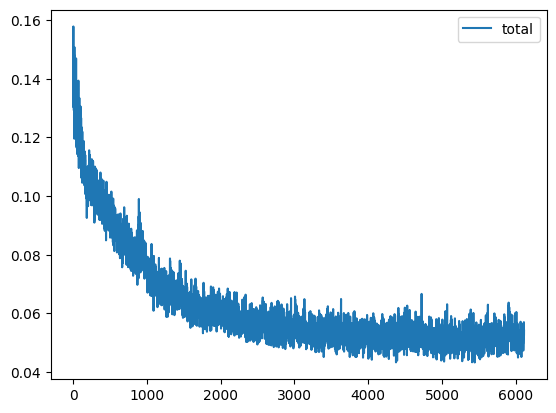

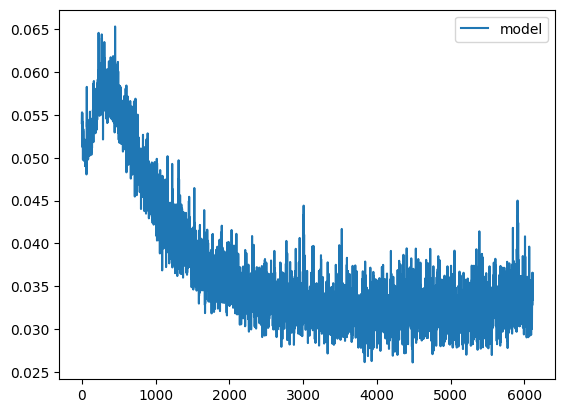

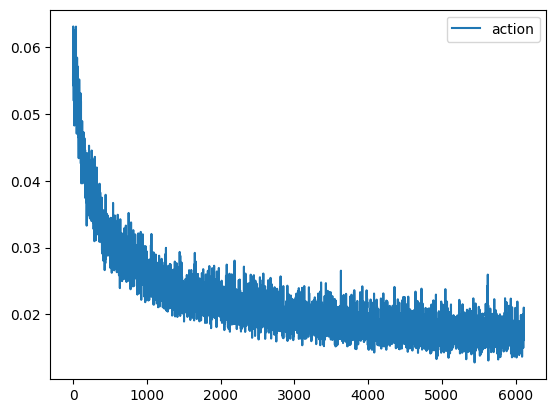

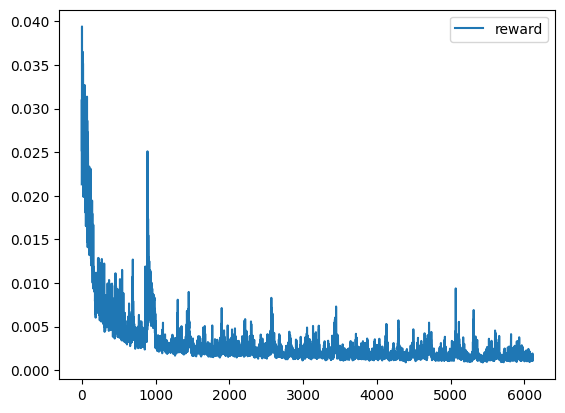

In [58]:
import matplotlib.pyplot as plt
plt.plot(losses[100:], label='total')
plt.legend()
plt.show()


plt.plot(model_losses[100:], label='model')
plt.legend()
plt.show()

plt.plot(action_losses[100:], label='action')
plt.legend()
plt.show()

plt.plot(reward_losses[100:], label='reward')
plt.legend()
plt.show()

Model loss: 0.021407531574368477
Model loss (shuffle): 0.5815141797065735Inv model loss: 0.0203340295702219
Inv model loss (shuffle): 0.07083292305469513


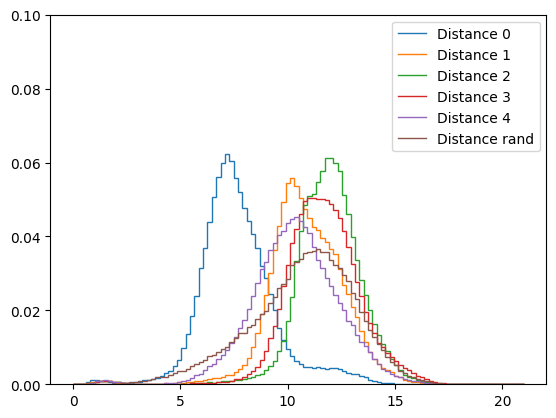

Model loss: 0.004649931564927101
Model loss (shuffle): 0.14496542513370514Inv model loss: 0.0046584876254200935
Inv model loss (shuffle): 0.017608605325222015


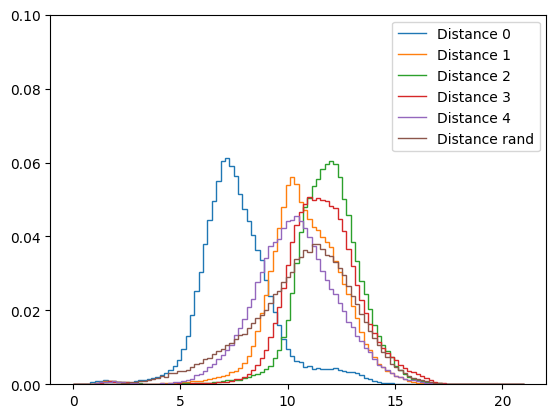

In [59]:
# validate that model is accurate

val_set_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

def plot_hists(loader):
    model_loss_total = 0
    model_loss_shuffle = 0
    inv_model_loss_total = 0
    inv_model_loss_shuffle = 0
    bins = np.linspace(0, 20, 100, endpoint=True)
    bins = np.concatenate([bins, [10000]])
    hists = dict()
    max_batches = 500
    with torch.no_grad():
        for batch_i, batch in enumerate(loader):
            z = encoder(batch['observations'])
            z_next = encoder(batch['next_observations'])
            z_pred = forward_model(z, batch['actions'])
            for i in range(z_next.shape[1]):
                hists[i] = hists.get(i, np.zeros_like(bins[:-1]))
                dist = torch.norm(z[:, 0] - z_next[:, i], dim=-1)
                hists[i] += np.histogram(dist.cpu().numpy(), bins=bins)[0]
            hists["rand"] = hists.get("rand", np.zeros_like(bins[:-1]))
            dist_rand = torch.norm(z[:, 0] - z_next[torch.randperm(len(z)), 0], dim=-1)
            hists["rand"] += np.histogram(dist_rand.cpu().numpy(), bins=bins)[0]


            model_loss_total += model_loss_fn(z_pred, z_next)
            model_loss_shuffle += model_loss_fn(z_pred, z_next[torch.randperm(len(z))])

            action_pred = inv_model(torch.cat([z[:, 0], z_next[:, 2]], dim=-1))
            action_pred_rand = inv_model(torch.cat([z[:, 0], z_next[torch.randperm(len(z)), 2]], dim=-1))
            inv_model_loss_total += F.mse_loss(action_pred, batch['actions'][:, 0])
            inv_model_loss_shuffle += F.mse_loss(action_pred_rand, batch['actions'][:, 0])

            if batch_i > max_batches:
                break
    print(
        f"Model loss: {model_loss_total / len(loader)}\n"
        f"Model loss (shuffle): {model_loss_shuffle / len(loader)}"
        f"Inv model loss: {inv_model_loss_total / len(loader)}\n"
        f"Inv model loss (shuffle): {inv_model_loss_shuffle / len(loader)}"
    )

    plotting_bins = np.copy(bins)
    plotting_bins[-1] = plotting_bins[-2] + 1
    for key, val in hists.items():
        if key in set(range(5, 1000)):
            continue
        val /= np.sum(val)
        plt.stairs(val, plotting_bins, label=f"Distance {key}")
    plt.legend()
    plt.ylim(0, 0.1)
    plt.show()

plot_hists(val_set_loader)
plot_hists(dataloader)

In [60]:
from pynndescent import NNDescent
from dataclasses import dataclass

next_state_distance = 2
num_obs = sum([len(traj["observations"]) for traj in trajs]) - next_state_distance * len(trajs)

obs_norm = np.zeros((num_obs, latent_dim), dtype=np.float32)
z_next = np.zeros((num_obs, latent_dim), dtype=np.float32)

returns = np.zeros(num_obs, dtype=np.float32)
actions = np.zeros((num_obs, trajs[0]['actions'].shape[1]), dtype=np.float32)

ind = 0
for traj in tqdm(trajs):
    indices = slice(ind, ind+traj['observations'].shape[0] - next_state_distance)
    obs = traj['observations']
    z = encoder(torch.tensor(obs, dtype=torch.float32)).detach().cpu().numpy()
    obs_norm[indices] = z[:-next_state_distance]
    z_next[indices] = z[next_state_distance:]
    returns[indices] = traj['returns'][:-next_state_distance]
    actions[indices] = traj['actions'][:-next_state_distance].detach().cpu().numpy()
    ind += traj['observations'].shape[0] - next_state_distance

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]/home/eop/code/CORL/venv/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.49it/s]


In [61]:
np.linalg.norm(obs_norm[0] - obs_norm[1])

4.7559867

In [62]:
index = NNDescent(obs_norm, metric='euclidean')

In [63]:
from algorithms.offline.knn import wrap_env

eval_env = wrap_env(
    env=gym.make(env_name),
    state_mean=obs_mean,
    state_std=obs_std,
    reward_scale=1.0,
)
eval_episodes = 100
k=1


/home/eop/code/CORL/venv/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [64]:
s = eval_env.reset()
z = encoder(torch.tensor(s, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
idx, dist = index.query(z[0], k=500)
idx, dist

(array([[714568, 264470, 778440, 439120, 290418, 569858, 759478, 131736,
         997002, 561874, 993010, 842312, 684628, 776444, 796404, 112774,
         300398, 745506, 770456, 380238, 117764, 784428, 138722, 742512,
         413172, 659678,  92814, 557882, 913170, 216566, 524948, 837322,
         519958,  28942, 882232, 568860, 599798, 991014, 233532, 542912,
         228542,  30938, 940116, 301396, 813370, 983030,  94810, 377244,
         840316, 663670, 874248, 889218, 426146, 428142, 293412, 499000,
         650696, 123752, 472054, 364270, 355288, 879238, 357284, 443112,
         624748, 711574, 606784, 958080, 304390, 489020, 916164, 521954,
         257484, 118762, 230538, 145708, 823350, 403192, 149700, 269460,
         237524, 390218, 641714, 787422, 854288, 855286, 547902, 614768,
         750496, 486026, 500996, 535926, 420158, 354290, 604788, 953090,
         459080, 128742, 730536, 388222,  18962, 948100, 122754, 689618,
         393212, 444110,  74850, 877242, 464070, 56

In [65]:

def eval():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        idxs, dists = index.query(z[0], k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]

        action = actions[best_idx]
        obs, reward, done, _ = eval_env.step(action)
        total_reward += reward
    return total_reward


eval_rets = [eval() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets), env.get_normalized_score(np.mean(eval_rets)) * 100.0

(4642.435115525197, 39.649964669544275)

In [66]:
def eval_inv_model():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()[0]
        idxs, dists = index.query(z, k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]

        action = inv_model(torch.tensor(np.concatenate([z, z_next[best_idx][None,:]], axis=-1), dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        obs, reward, done, _ = eval_env.step(action.squeeze())
        total_reward += reward
    return total_reward


eval_rets_inv = [eval_inv_model() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets_inv), env.get_normalized_score(np.mean(eval_rets_inv)) * 100.0

(4717.075701502848, 40.25116893941599)